# Gesture Recognition

### Problem Statement
A home electronics company which manufactures state of the art smart televisions want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
 
| Gesture | Corresponding Action |
| --- | --- | 
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |

Each video is a sequence of 30 frames (or images).

**To build a model to recognise above 5 hand gestures.**

### Understanding the dataset

The training data consists of a few hundred videos categorised into one of the five classes. Each video (typically 2-3 seconds long) is divided into a sequence of 30 frames(images). These videos have been recorded by various people performing one of the five gestures in front of a webcam - similar to what the smart TV will use. 

All images in a particular video subfolder have the same dimensions but different videos may have different dimensions. Specifically, videos have two types of dimensions - either 360x360 or 120x160 (depending on the webcam used to record the videos). Hence, you will need to do some pre-processing to standardise the videos. 

Each row of the CSV file represents one video and contains three main pieces of information - the name of the subfolder containing the 30 images of the video, the name of the gesture and the numeric label (between 0-4) of the video.

### Objectives:

1. **Generator**:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. **Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. 

3. **Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model. 

In [1]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os
import matplotlib.pyplot as plt
import cv2

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout,LSTM
from keras.layers.convolutional import Conv3D,Conv2D, MaxPooling3D,MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications.resnet import ResNet50
from keras.applications.resnet import preprocess_input
from keras.layers.recurrent import LSTM, GRU

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [3]:
train_doc = np.random.permutation(open('datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('datasets/Project_data/val.csv').readlines())
batch_size = 20 #experiment with the batch size

**Building function to plot the result**

In [4]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(1,2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
# normalization 
def image_normalisation(img):
    # using min max normalization to get better result
    normalized_image= (img - np.min(img))/(np.max(img)- np.min(img))
    return normalized_image

In [6]:
# Generatot Function 
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx =[x for x in range(0, 30,2)]  #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,15,120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resized_image=resize(image, (120,120))
                    
                    batch_data[folder,idx,:,:,0] = image_normalisation(resized_image[:, : , 0])#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image_normalisation(resized_image[:, : , 1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image_normalisation(resized_image[:, : , 2])#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [7]:
curr_dt_time = datetime.datetime.now()
train_path = 'datasets/Project_data/train'
val_path = 'datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 15


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Model - Conv-3D

In [8]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here
# Input
# input_shape = (frame, height, width, no. of chaanels)
input_shape=(15,120,120,3)

model3d = Sequential()
model3d.add(Conv3D(8,kernel_size=(5,5,5),input_shape=input_shape,padding='same'))
model3d.add(Activation('relu'))
model3d.add(BatchNormalization())

model3d.add(Conv3D(16,kernel_size=(3,3,3),padding='same'))
model3d.add(Activation('relu'))
model3d.add(BatchNormalization())
model3d.add(MaxPooling3D(pool_size=(2,2,2)))

model3d.add(Conv3D(32,kernel_size=(1,3,3),padding='same'))
model3d.add(Activation('relu'))
model3d.add(BatchNormalization())
model3d.add(MaxPooling3D(pool_size=(2,2,2)))

model3d.add(Dropout(0.25))


model3d.add(Flatten())
model3d.add(Dense(128, activation='relu'))
model3d.add(Dropout(0.2))
model3d.add(Dense(64, activation='relu'))
#softmax layer
model3d.add(Dense(5, activation='softmax'))

2022-06-13 08:06:32.150262: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-06-13 08:06:32.150331: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1e:00.0, compute capability: 7.5


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [9]:
from tensorflow.keras.optimizers import Adam

optimiser =Adam(0.001) #write your optimizer
model3d.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3d.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 120, 120, 8)   3008      
                                                                 
 activation (Activation)     (None, 15, 120, 120, 8)   0         
                                                                 
 batch_normalization (BatchN  (None, 15, 120, 120, 8)  32        
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 120, 120, 16)  3472      
                                                                 
 activation_1 (Activation)   (None, 15, 120, 120, 16)  0         
                                                                 
 batch_normalization_1 (Batc  (None, 15, 120, 120, 16)  64       
 hNormalization)                                        

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [10]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [11]:
model_name = 'model3d' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, cooldown=4, verbose=1,mode='auto',epsilon=0.0001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [12]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [13]:
history = model3d.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_744/2529974850.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model3d.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  datasets/Project_data/train ; batch size = 20
Epoch 1/15


2022-06-13 08:06:35.839805: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 6.8089 - categorical_accuracy: 0.3588Source path =  datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model3d_2022-06-1308_06_30.333760/model-00001-6.80887-0.35882-8.12269-0.23000.h5
34/34 [==============================] - 87s 2s/step - loss: 6.8089 - categorical_accuracy: 0.3588 - val_loss: 8.1227 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/15
34/34 [==============================] - ETA: 0s - loss: 4.4290 - categorical_accuracy: 0.3627
Epoch 00002: saving model to model3d_2022-06-1308_06_30.333760/model-00002-4.42903-0.36275-3.47749-0.39000.h5
34/34 [==============================] - 27s 806ms/step - loss: 4.4290 - categorical_accuracy: 0.3627 - val_loss: 3.4775 - val_categorical_accuracy: 0.3900 - lr: 0.0010
Epoch 3/15
34/34 [==============================] - ETA: 0s - loss: 4.4854 - categorical_accuracy: 0.3529
Epoch 00003: saving model to model3d_2022-06-1308_06_30.333760/model-00003-4.48

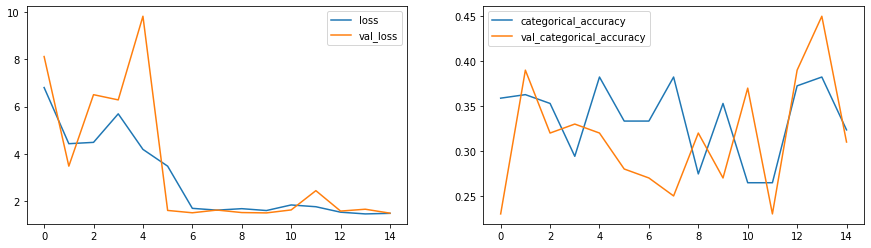

In [14]:
plot(history)

We can observe that the training accuracy is around 32% and validation accuracy is around 31%. Let's try with CNN and RNN to check whether the accuracy is increasing or not. 

## Model 2 - CNN + RNN

In [15]:
# to create a new different folder for different model
curr_dt_time = datetime.datetime.now()
train_path = 'datasets/Project_data/train'
val_path = 'datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 15


In [16]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout,LSTM
from keras.layers.convolutional import Conv3D,Conv2D, MaxPooling3D,MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers.recurrent import LSTM, GRU

# Input
# input_shape = (frame, height, width, no. of chaanels)
input_shape=(15,120,120,3)

model_cnn_rnn = Sequential()

model_cnn_rnn.add(TimeDistributed(Conv2D(8, (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))
model_cnn_rnn.add(TimeDistributed(Conv2D(16, (3,3),padding='same', activation='relu')))
model_cnn_rnn.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model_cnn_rnn.add(TimeDistributed(Conv2D(32, (3,3),padding='same', activation='relu')))
model_cnn_rnn.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model_cnn_rnn.add(TimeDistributed(Conv2D(64, (2,2),padding='same', activation='relu')))
model_cnn_rnn.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model_cnn_rnn.add(TimeDistributed(BatchNormalization()))
model_cnn_rnn.add(Dropout(0.25))

model_cnn_rnn.add(TimeDistributed(Flatten()))

model_cnn_rnn.add(Dense(128, activation='relu'))
model_cnn_rnn.add(Dropout(0.2))
model_cnn_rnn.add(Dense(64, activation='relu'))
model_cnn_rnn.add(Dropout(0.2))

model_cnn_rnn.add(GRU(128, return_sequences=False))
model_cnn_rnn.add(Dense(5, activation='softmax')) # using Softmax as last layer

In [17]:
# compiling model
from tensorflow.keras.optimizers import Adam

optimiser =Adam(0.001) #write your optimizer
model_cnn_rnn.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_cnn_rnn.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 60, 60, 8)    224       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 60, 60, 16)   1168      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 30, 30, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 30, 30, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 15, 15, 15, 32)  

In [18]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [19]:
model_name = 'model_cnn_rnn' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, cooldown=4, verbose=1,mode='auto',epsilon=0.0001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [20]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [21]:
history = model_cnn_rnn.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 20


/tmp/ipykernel_744/1509877065.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_cnn_rnn.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/15
34/34 [==============================] - ETA: 0s - loss: 1.3151 - categorical_accuracy: 0.4162Source path =  datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_cnn_rnn_2022-06-1308_14_09.307415/model-00001-1.31513-0.41618-1.58255-0.25000.h5
34/34 [==============================] - 87s 3s/step - loss: 1.3151 - categorical_accuracy: 0.4162 - val_loss: 1.5825 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/15
34/34 [==============================] - ETA: 0s - loss: 1.2330 - categorical_accuracy: 0.5392
Epoch 00002: saving model to model_cnn_rnn_2022-06-1308_14_09.307415/model-00002-1.23297-0.53922-1.55260-0.27000.h5
34/34 [==============================] - 25s 762ms/step - loss: 1.2330 - categorical_accuracy: 0.5392 - val_loss: 1.5526 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 3/15
34/34 [==============================] - ETA: 0s - loss: 1.3644 - categorical_accuracy: 0.4706
Epoch 00003: saving model to model_cnn_rnn_2022-06-1308_

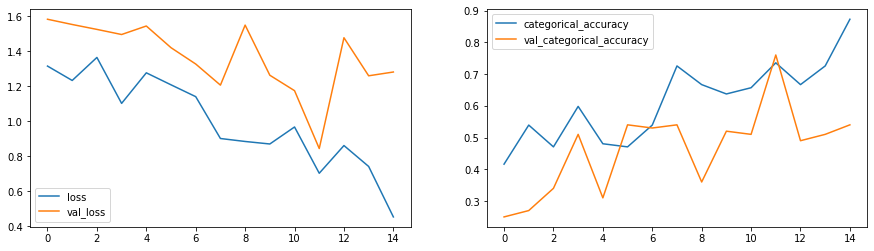

In [22]:
plot(history)

As we can observe that the training accuracy is around 84% and validation accuracy is around 54%. There is overfitting in the model. But we will try to reduce overfitting and also try to check whether augmentation increases the accuracy or not.

## Model 3 - Conv-3d (With augmentation)

In [23]:
# Generatot Function 
def generator_aug(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx =[x for x in range(0, 30,2)]  #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,15,120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            batch_data_aug = np.zeros((batch_size,15,120,120,3))
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image_resized=resize(image,(120,120,3))

                    #normalizing the images
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255

                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))

                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    # cropping the images to have the targeted gestures and remove the noise from the images.
                    cropped=shifted[x0:x1,y0:y1,:]

                    image_resized=resize(image, (120,120))


                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255


                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                batch_data=np.concatenate([batch_data,batch_data_aug])
                batch_labels=np.concatenate([batch_labels,batch_labels])
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            yield batch_data, batch_labels

In [24]:
# to create a new different folder for different model
curr_dt_time = datetime.datetime.now()
train_path = 'datasets/Project_data/train'
val_path = 'datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 15


In [25]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout,LSTM
from keras.layers.convolutional import Conv3D,Conv2D, MaxPooling3D,MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers.recurrent import LSTM, GRU

# Input
# input_shape = (frame, height, width, no. of chaanels)
input_shape=(15,120,120,3)

model3d_aug = Sequential()
model3d_aug.add(Conv3D(8,kernel_size=(5,5,5),input_shape=input_shape,padding='same'))
model3d_aug.add(Activation('relu'))
model3d_aug.add(BatchNormalization())

model3d_aug.add(Conv3D(16,kernel_size=(3,3,3),padding='same'))
model3d_aug.add(Activation('relu'))
model3d_aug.add(BatchNormalization())
model3d_aug.add(MaxPooling3D(pool_size=(2,2,2)))

model3d_aug.add(Conv3D(32,kernel_size=(1,3,3),padding='same'))
model3d_aug.add(Activation('relu'))
model3d_aug.add(BatchNormalization())
model3d_aug.add(MaxPooling3D(pool_size=(2,2,2)))

model3d_aug.add(Dropout(0.25))


model3d_aug.add(Flatten())
model3d_aug.add(Dense(128, activation='relu'))
model3d_aug.add(Dropout(0.2))
model3d_aug.add(Dense(64, activation='relu'))
#softmax layer
model3d_aug.add(Dense(5, activation='softmax'))

In [26]:
# compiling model
from tensorflow.keras.optimizers import Adam

optimiser =Adam(0.001) #write your optimizer
model3d_aug.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3d_aug.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 15, 120, 120, 8)   3008      
                                                                 
 activation_3 (Activation)   (None, 15, 120, 120, 8)   0         
                                                                 
 batch_normalization_4 (Batc  (None, 15, 120, 120, 8)  32        
 hNormalization)                                                 
                                                                 
 conv3d_4 (Conv3D)           (None, 15, 120, 120, 16)  3472      
                                                                 
 activation_4 (Activation)   (None, 15, 120, 120, 16)  0         
                                                                 
 batch_normalization_5 (Batc  (None, 15, 120, 120, 16)  64       
 hNormalization)                                      

In [27]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [28]:
model_name = 'model_cnn3d_aug' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, cooldown=4, verbose=1,mode='auto',epsilon=0.0001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [29]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [30]:
history = model3d_aug.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 20


/tmp/ipykernel_744/1513450782.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model3d_aug.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/15
34/34 [==============================] - ETA: 0s - loss: 7.0296 - categorical_accuracy: 0.3309Source path =  datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_cnn3d_aug_2022-06-1308_21_38.909409/model-00001-7.02955-0.33088-9.30419-0.23000.h5
34/34 [==============================] - 86s 3s/step - loss: 7.0296 - categorical_accuracy: 0.3309 - val_loss: 9.3042 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/15
34/34 [==============================] - ETA: 0s - loss: 2.9870 - categorical_accuracy: 0.3922
Epoch 00002: saving model to model_cnn3d_aug_2022-06-1308_21_38.909409/model-00002-2.98698-0.39216-11.42406-0.26000.h5
34/34 [==============================] - 24s 739ms/step - loss: 2.9870 - categorical_accuracy: 0.3922 - val_loss: 11.4241 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 3/15
34/34 [==============================] - ETA: 0s - loss: 3.1909 - categorical_accuracy: 0.4020
Epoch 00003: saving model to model_cnn3d_aug_2022-

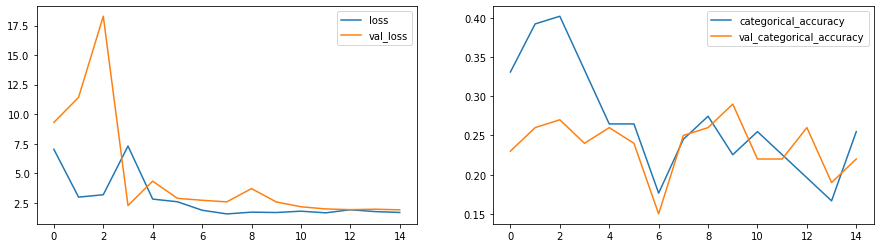

In [31]:
plot(history)

We can see that while using augmentation it reduces the accuracy of training and validation slightly. We can say that, in our case adding augmentation, didn't affect any accuracy.

## Model 4 - CNN + RNN (With augmentation)

In [32]:
# to create a new different folder for different model
curr_dt_time = datetime.datetime.now()
train_path = 'datasets/Project_data/train'
val_path = 'datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 15


In [33]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout,LSTM
from keras.layers.convolutional import Conv3D,Conv2D, MaxPooling3D,MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers.recurrent import LSTM, GRU

# Input
# input_shape = (frame, height, width, no. of chaanels)
input_shape=(15,120,120,3)

model_cnn_rnn_aug = Sequential()

model_cnn_rnn_aug.add(TimeDistributed(Conv2D(8, (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))
model_cnn_rnn_aug.add(TimeDistributed(Conv2D(16, (3,3),padding='same', activation='relu')))
model_cnn_rnn_aug.add(TimeDistributed(BatchNormalization()))
model_cnn_rnn_aug.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model_cnn_rnn_aug.add(TimeDistributed(Conv2D(32, (3,3),padding='same', activation='relu')))
model_cnn_rnn_aug.add(TimeDistributed(BatchNormalization()))
model_cnn_rnn_aug.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model_cnn_rnn_aug.add(TimeDistributed(Conv2D(64, (2,2),padding='same', activation='relu')))
model_cnn_rnn_aug.add(TimeDistributed(BatchNormalization()))
model_cnn_rnn_aug.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))


model_cnn_rnn_aug.add(Dropout(0.25))
model_cnn_rnn_aug.add(TimeDistributed(Flatten()))
model_cnn_rnn_aug.add(Dense(128, activation='relu'))
model_cnn_rnn_aug.add(Dropout(0.2))
model_cnn_rnn_aug.add(Dense(64, activation='relu'))
model_cnn_rnn_aug.add(Dropout(0.2))

model_cnn_rnn_aug.add(GRU(128, return_sequences=False))
model_cnn_rnn_aug.add(Dense(5, activation='softmax')) # using Softmax as last layer

In [34]:
# compiling model
from tensorflow.keras.optimizers import Adam

optimiser =Adam(0.001) #write your optimizer
model_cnn_rnn_aug.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_cnn_rnn_aug.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_9 (TimeDis  (None, 15, 60, 60, 8)    224       
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 15, 60, 60, 16)   1168      
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 15, 60, 60, 16)   64        
 stributed)                                                      
                                                                 
 time_distributed_12 (TimeDi  (None, 15, 30, 30, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 15, 30, 30, 32)  

In [35]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [36]:
model_name = 'model_cnn_rnn_aug' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, cooldown=4, verbose=1,mode='auto',epsilon=0.0001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [37]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [38]:
history = model_cnn_rnn_aug.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 20


/tmp/ipykernel_744/1272798878.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_cnn_rnn_aug.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/15
34/34 [==============================] - ETA: 0s - loss: 1.4866 - categorical_accuracy: 0.3809Source path =  datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_cnn_rnn_aug_2022-06-1308_29_15.544158/model-00001-1.48664-0.38088-1.58680-0.29000.h5
34/34 [==============================] - 88s 3s/step - loss: 1.4866 - categorical_accuracy: 0.3809 - val_loss: 1.5868 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 2/15
34/34 [==============================] - ETA: 0s - loss: 1.3239 - categorical_accuracy: 0.4902
Epoch 00002: saving model to model_cnn_rnn_aug_2022-06-1308_29_15.544158/model-00002-1.32390-0.49020-2.43832-0.22000.h5
34/34 [==============================] - 27s 815ms/step - loss: 1.3239 - categorical_accuracy: 0.4902 - val_loss: 2.4383 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/15
34/34 [==============================] - ETA: 0s - loss: 1.5576 - categorical_accuracy: 0.4216
Epoch 00003: saving model to model_cnn_rnn_aug_2

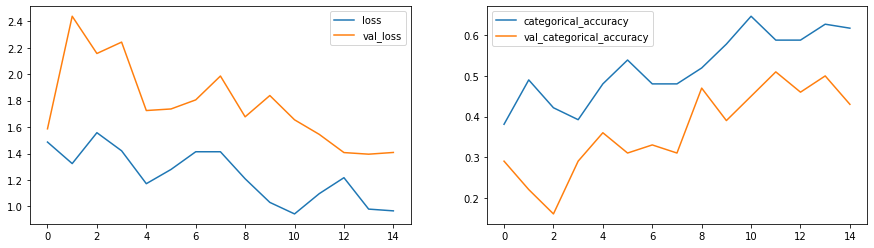

In [39]:
plot(history)

We can see that overfitting in CNN+RNN(without augmentation) has been overcomed with the help of augmentation. The accuracy of validation is decreased slightly from around 52% to 43% but the training accuracy is decreased drastically from 84% to around 60%.

## Conclusion

Following are the conclusions:

- Initially we build a simple **Conv-3D** model, we got an training accuracy of around 32% and validation accuracy of around 31%. There is no clear sign of overfitting.
- We have seen that, with the help of **data augmentation method**, there was no improvement in **Conv-3D** model compared to non augmented data. 
- Secondly, we build a **CNN-RNN** model, we got a training accuracy of around 80% and validation accuracy of around 54%. It is a clear sign of overfitting.
- We have seen that, with the help of **data augmentation method**, there was improvement in **CNN-RNN** model compared to non augmented data. In our case it reduced the overfitting, but decreased our training accuracy(approx. 60%) and validation accuracy(approx. 43%)

We can say that in our casa the CNN-RNN model with data augmentation gives better results compare to other models.